### Exploración datos de coordenadas para el MAPA


In [41]:
import pandas as pd

df = pd.read_csv('../../data/ex2/preprocess_mapa.csv')
df['date_time'] = pd.to_datetime(df['ts_kafka'],unit='ms')

In [154]:
df.head()

,ts_kafka,velocity,lat,lon,icao,ground,direccion,alt_feet,date_time
0,1733030745974,NaN,NaN,NaN,000000,NaN,NaN,NaN,2024-12-01 05:25:45.974
1,1733032305075,NaN,NaN,NaN,000000,NaN,NaN,NaN,2024-12-01 05:51:45.075
2,1733032535230,476.0,38.594238,-5.025648,02009f,0.0,NaN,40000.0,2024-12-01 05:55:35.230
3,1733032836180,474.0,39.214188,-4.736421,02009f,0.0,1.134285,40000.0,2024-12-01 06:00:36.180
4,1733033137129,469.0,39.826401,-4.413757,02009f,0.0,1.097816,40000.0,2024-12-01 06:05:37.129


### Latitud y Longitud

Vemos la cantidad de valores vacíos

In [43]:
df.shape

(4608, 9)

In [44]:
df.isna().sum()

ts_kafka        0
velocity     2747
lat          2729
lon          2729
icao            0
ground       2551
direccion    3070
alt_feet     2818
date_time       0
dtype: int64

Aparecen **muchos valores vacios**, eliminamos aquellos que no tienen latitud ni longitud

**Correlaciones entre los nulos de diferentes columnas**

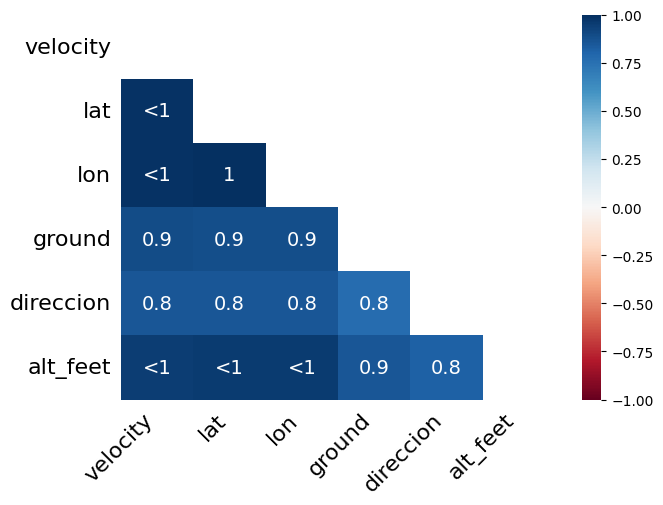

In [75]:
import missingno as msno 

msno.heatmap(df, figsize=(7,5));

La conclusión que aparece parece ser la de que si hay algún nulo en alguna columna, en las demás también habrá un nulo seguramente, de modo que tenemos:
1. Filas donde todos los datos están completos.
2. Filas donde todos los datos están vacíos.

In [76]:
print("ANTES:", df.shape)
df_lat_lon = df[~df.lat.isna() & ~df.lon.isna()]
print("DESPUES:", df_lat_lon.shape)

ANTES: (4608, 9)
DESPUES: (1879, 9)


In [77]:
df_lat_lon.isna().sum()

ts_kafka       0
velocity      24
lat            0
lon            0
icao           0
ground        38
direccion    341
alt_feet      89
date_time      0
dtype: int64

In [78]:
df_lat_lon.icao.value_counts().sort_values(ascending=False)

icao
344115    78
02019d    17
347691    12
4cae67    12
34644c    11
          ..
346185     1
4a1922     1
4b1920     1
4bb183     1
4ca9d3     1
Name: count, Length: 324, dtype: int64

In [79]:
print("TAMAÑO DATOS:", df_lat_lon.shape)
print("VALORES UNICOS LONGITUD:", df_lat_lon.lon.unique().shape)
print("VALORES UNICOS LATITUD:", df_lat_lon.lat.unique().shape)

TAMAÑO DATOS: (1879, 9)
VALORES UNICOS LONGITUD: (1786,)
VALORES UNICOS LATITUD: (1787,)


### Velocidad

In [160]:
df_velocity = df_lat_lon[~df_lat_lon.velocity.isna()]
df_velocity

,ts_kafka,velocity,lat,lon,icao,ground,direccion,alt_feet,date_time
2,1733032535230,476.0,38.594238,-5.025648,02009f,0.0,NaN,40000.0,2024-12-01 05:55:35.230
3,1733032836180,474.0,39.214188,-4.736421,02009f,0.0,1.134285,40000.0,2024-12-01 06:00:36.180
4,1733033137129,469.0,39.826401,-4.413757,02009f,0.0,1.097816,40000.0,2024-12-01 06:05:37.129
5,1733033437336,470.0,40.418198,-4.062439,02009f,0.0,1.047774,40000.0,2024-12-01 06:10:37.336
6,1733033737623,470.0,41.006470,-3.696088,02009f,0.0,1.019112,40025.0,2024-12-01 06:15:37.623
...,...,...,...,...,...,...,...,...,...
4599,1733035311796,423.0,39.477127,-4.378589,e80475,0.0,0.583724,22025.0,2024-12-01 06:41:51.796
4600,1733035612033,373.0,39.870083,-3.861023,e80475,0.0,0.632275,13075.0,2024-12-01 06:46:52.033
4601,1733035912230,265.0,40.190598,-3.469971,e80475,0.0,0.676146,7250.0,2024-12-01 06:51:52.230
4602,1733036212216,161.0,40.441000,-3.503141,e80475,NaN,1.356682,2350.0,2024-12-01 06:56:52.216


In [161]:
df_velocity.icao.value_counts().sort_values(ascending=False)

icao
344115    78
02019d    17
4cae67    12
347691    12
34754c    11
          ..
44d068     1
440095     1
4bb183     1
4a1922     1
4b1920     1
Name: count, Length: 309, dtype: int64

Cogemos el avión con más filas de datos, ICAO 344115

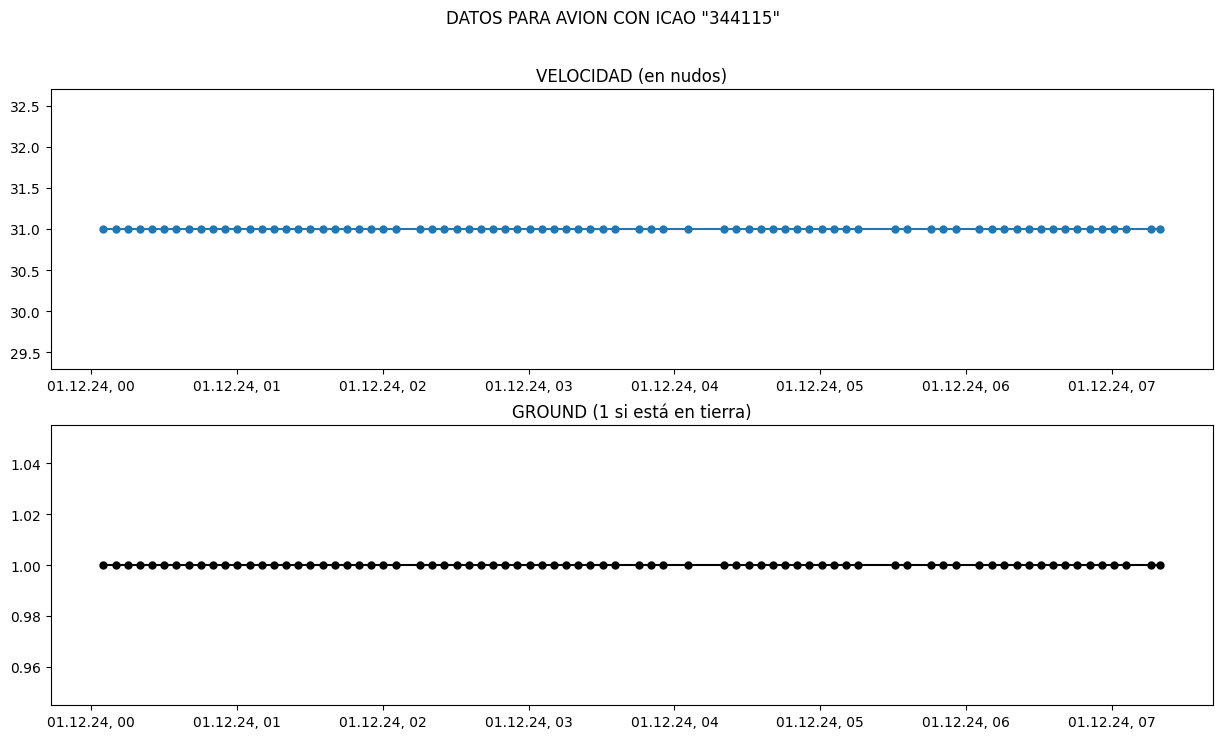

In [162]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

def plot_velocity_ground(data, icao):
    data = data[data.icao == icao]
    fig, axs = plt.subplots(2,1, figsize=(15, 8))
    axs[0].plot(data.date_time, data.velocity, marker='o', linestyle='-', markersize=5) 
    axs[1].plot(data.date_time, data.ground, color="black", marker='o', linestyle='-', markersize=5) 
    axs[0].set_title('VELOCIDAD (en nudos)')
    axs[1].set_title('GROUND (1 si está en tierra)')
    fig.suptitle(f'DATOS PARA AVION CON ICAO "{icao}"')
    myFmt = mdates.DateFormatter('%d.%m.%y, %H')
    for ax in axs:
        ax.xaxis.set_major_locator(mdates.AutoDateLocator())
        ax.xaxis.set_major_formatter(myFmt)

plot_velocity_ground(df_velocity, '344115')

Según las gráficas, el avión con ICAO 344115 está en tierra y se mueve con la misma velocidad durante 7 horas, algo bastante extraño

Pasamos a ver otro avión, el segundo con más datos, ICAO 02019d

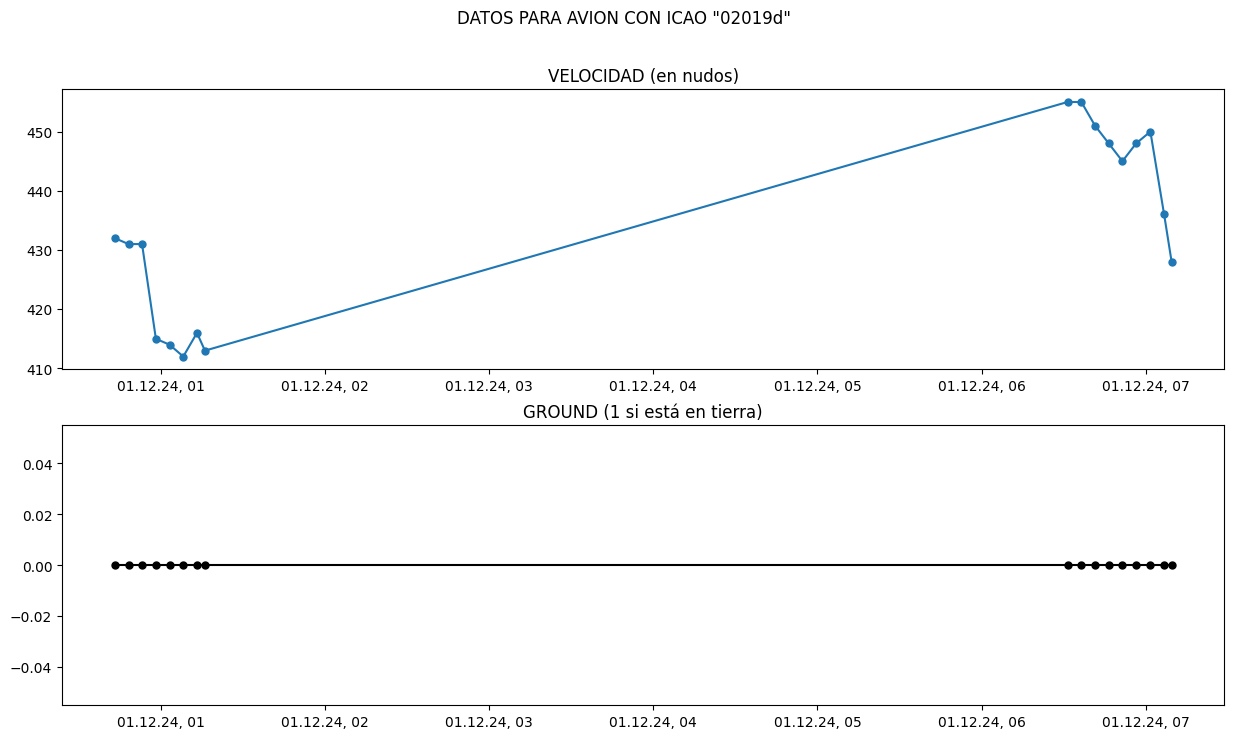

In [164]:
plot_velocity_ground(df_velocity, '02019d')

En este caso es un avión que no aterriza/despega en Madrid, sino que lo atraviesa (ground siempre 0). Pillamos dos de sus vuelos, uno a la 1 de la mañana, otro a las 7. En cuanto a velocidad, no hay un patrón que podamos destacar.

Intentamos encontrar un avión que ha estado en tierra y en aire

In [186]:
ground_icaos = df_velocity[df_velocity.ground == 1.0].icao.unique()
flying_icaos = df_velocity[df_velocity.ground == 0].icao.unique()
icaos_ground_fly = set(ground_icaos).intersection(set(flying_icaos))
df_velocity[df_velocity.icao.isin(icaos_ground_fly)].icao.value_counts()

icao
348212    9
3420cc    6
345215    5
Name: count, dtype: int64

Como son solo 3 aviones, los visualizamos todos

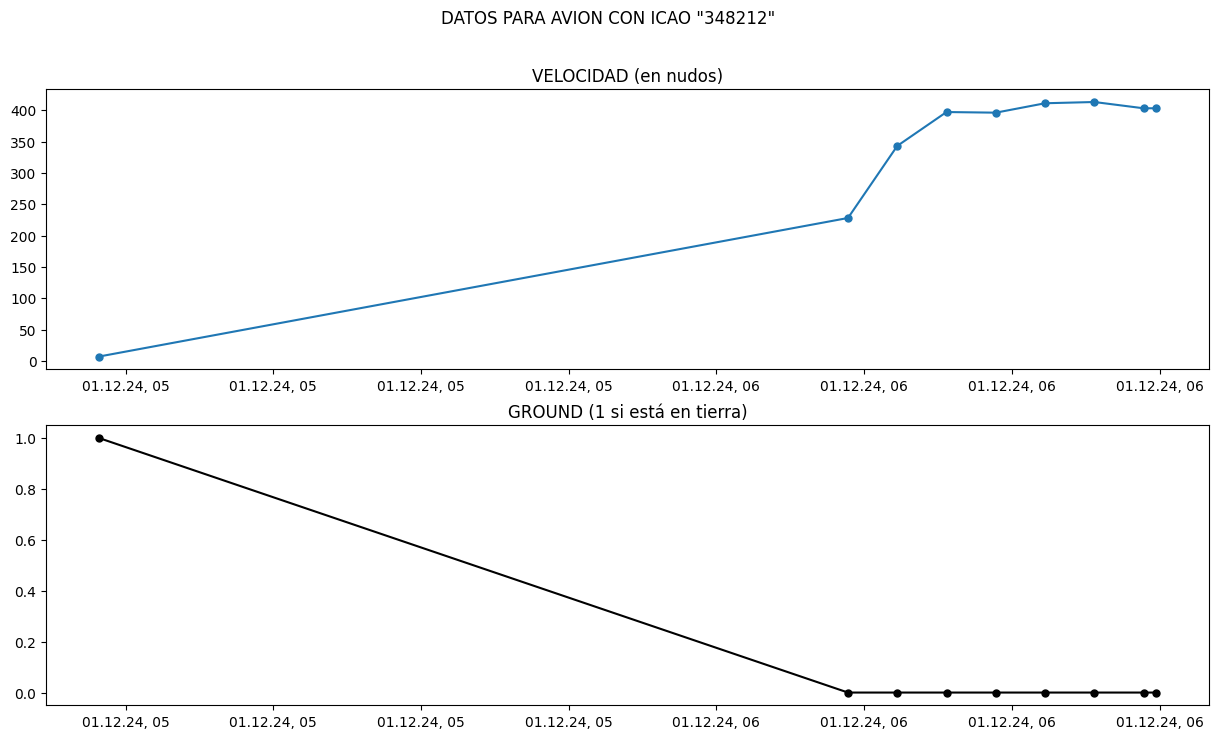

In [166]:
plot_velocity_ground(df_velocity, '348212')

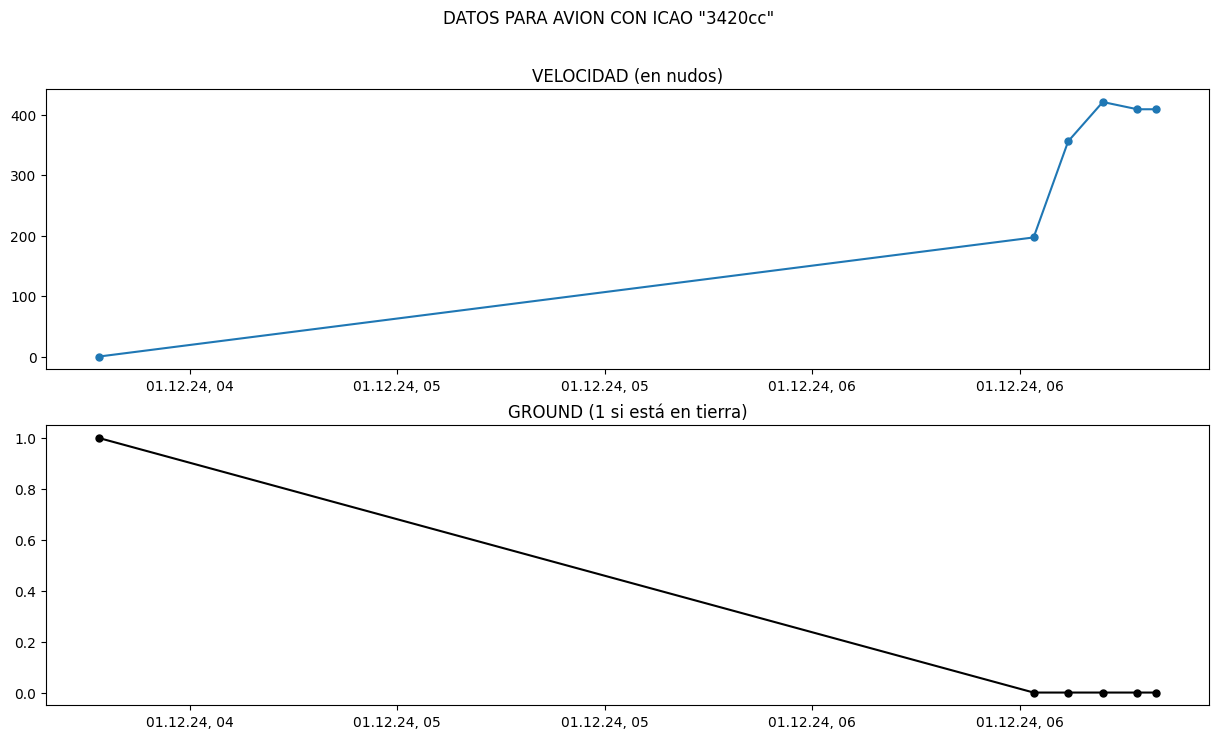

In [123]:
plot_velocity_ground(df_velocity, '3420cc')

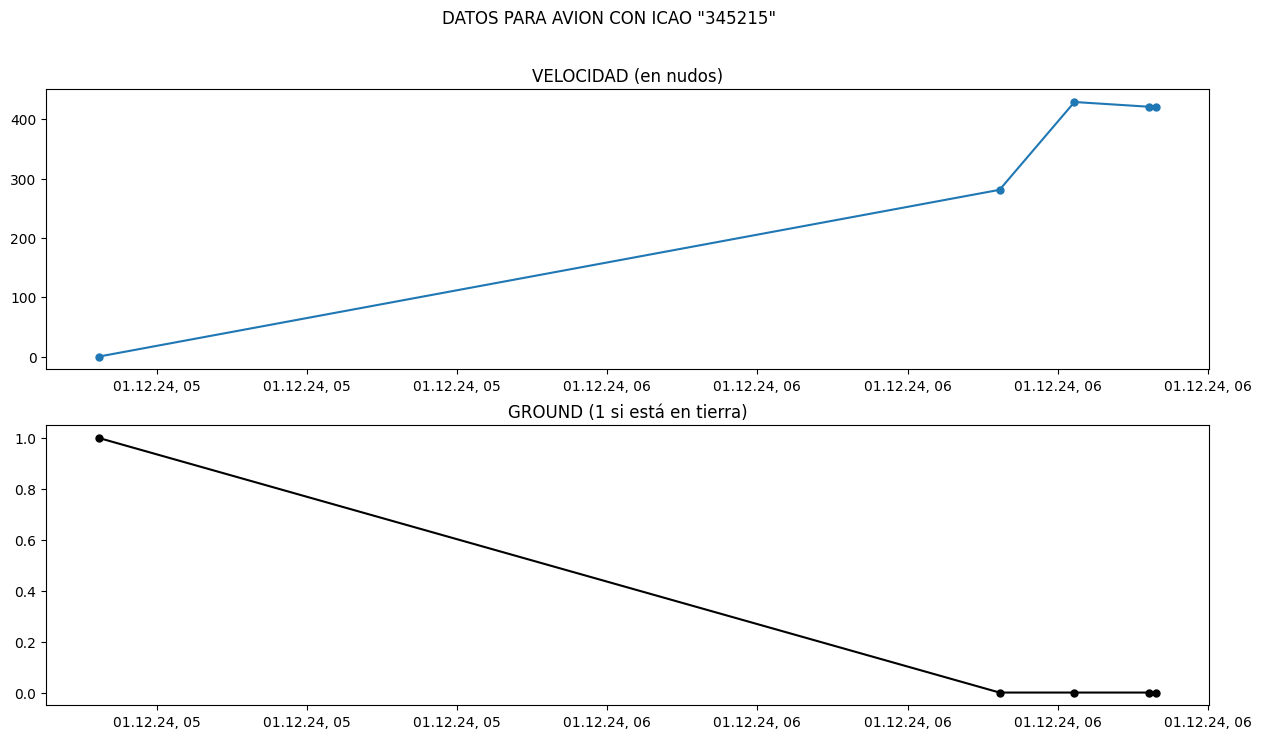

In [167]:
plot_velocity_ground(df_velocity, '345215')

No se captura bien el momento del despegue del avión, puede ser que en ese momento no transmite las coordenadas correctamente

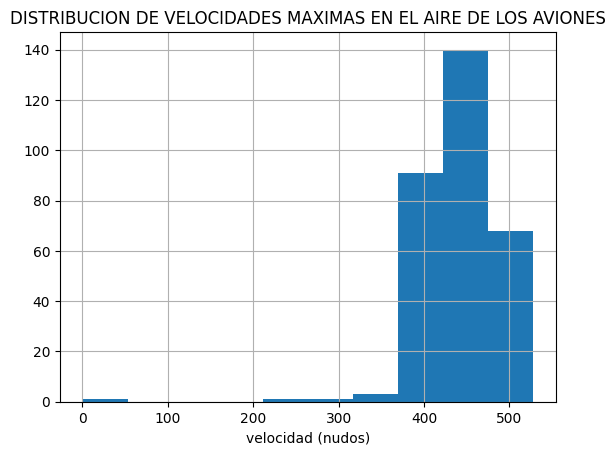

In [155]:
plt.title('DISTRIBUCION DE VELOCIDADES MAXIMAS EN EL AIRE DE LOS AVIONES')
plt.xlabel('velocidad (nudos)')
df_velocity[df_velocity.ground == 0].groupby('icao').max('velocity')['velocity'].hist();


Los aviones con velocidades mas bajas podrian estar aterrizando o despegando

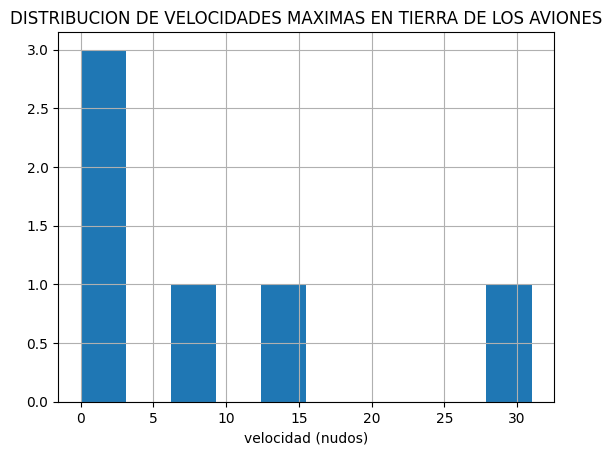

In [146]:
plt.title('DISTRIBUCION DE VELOCIDADES MAXIMAS EN TIERRA DE LOS AVIONES')
plt.xlabel('velocidad (nudos)')
df_velocity[df_velocity.ground == 1.0].groupby('icao').max('velocity')['velocity'].hist();

Vemos que en tierra no suele superar los 15 nudos de velocidad.

### Altura (feets)

In [169]:
df_altitude = df_lat_lon[~df_lat_lon.alt_feet.isna()]
df_altitude

,ts_kafka,velocity,lat,lon,icao,ground,direccion,alt_feet,date_time
2,1733032535230,476.0,38.594238,-5.025648,02009f,0.0,NaN,40000.0,2024-12-01 05:55:35.230
3,1733032836180,474.0,39.214188,-4.736421,02009f,0.0,1.134285,40000.0,2024-12-01 06:00:36.180
4,1733033137129,469.0,39.826401,-4.413757,02009f,0.0,1.097816,40000.0,2024-12-01 06:05:37.129
5,1733033437336,470.0,40.418198,-4.062439,02009f,0.0,1.047774,40000.0,2024-12-01 06:10:37.336
6,1733033737623,470.0,41.006470,-3.696088,02009f,0.0,1.019112,40025.0,2024-12-01 06:15:37.623
...,...,...,...,...,...,...,...,...,...
4599,1733035311796,423.0,39.477127,-4.378589,e80475,0.0,0.583724,22025.0,2024-12-01 06:41:51.796
4600,1733035612033,373.0,39.870083,-3.861023,e80475,0.0,0.632275,13075.0,2024-12-01 06:46:52.033
4601,1733035912230,265.0,40.190598,-3.469971,e80475,0.0,0.676146,7250.0,2024-12-01 06:51:52.230
4602,1733036212216,161.0,40.441000,-3.503141,e80475,NaN,1.356682,2350.0,2024-12-01 06:56:52.216


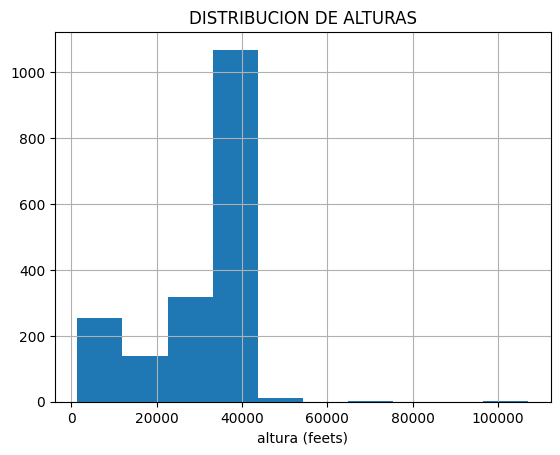

In [174]:
plt.title('DISTRIBUCION DE ALTURAS')
plt.xlabel('altura (feets)')
df_altitude.alt_feet.hist();

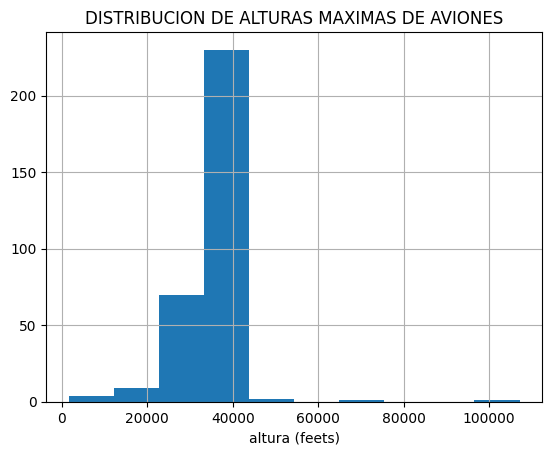

In [175]:
plt.title('DISTRIBUCION DE ALTURAS MAXIMAS DE AVIONES')
plt.xlabel('altura (feets)')
df_altitude.groupby('icao').max('alt_feet')['alt_feet'].hist();

In [180]:
df_altitude.icao.value_counts().sort_values(ascending=False)

icao
02019d    17
347691    12
4cae67    12
34754c    11
34644c    11
          ..
020145     1
4d223a     1
5a3653     1
4d234a     1
62e2fe     1
Name: count, Length: 317, dtype: int64

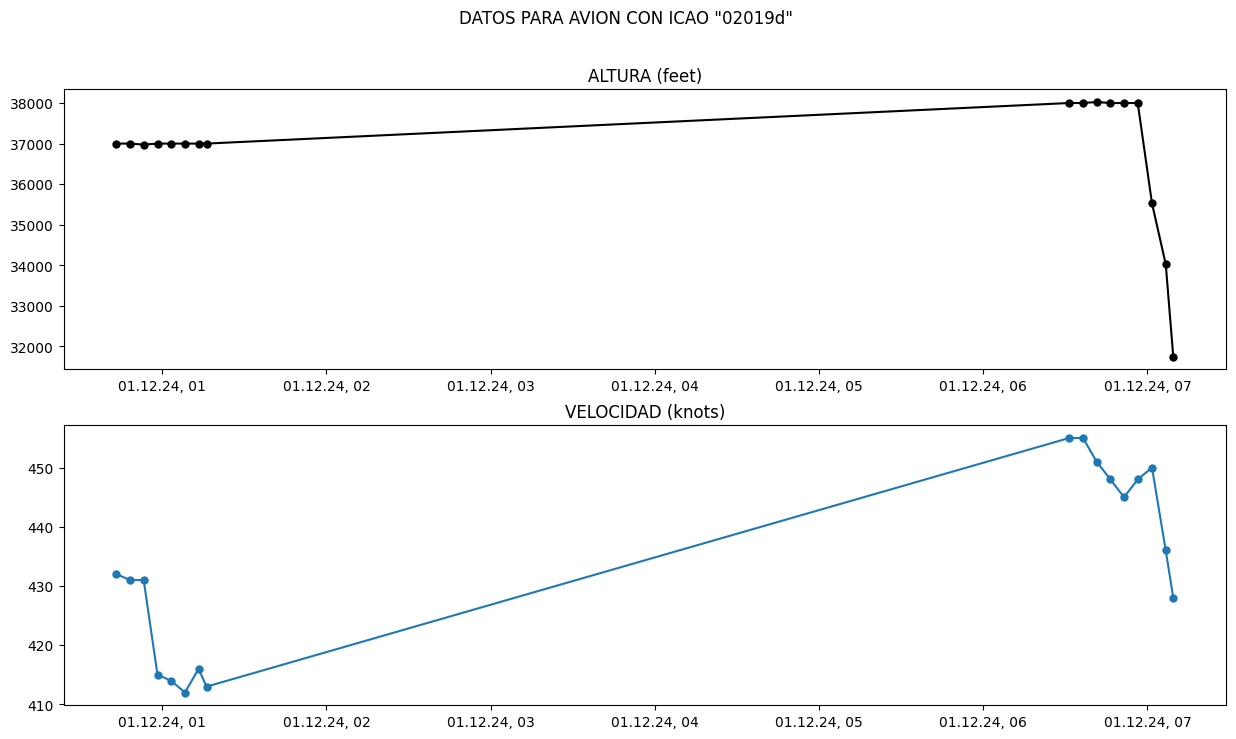

In [182]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

def plot_velocity_altitude(data, icao):
    data = data[data.icao == icao]
    fig, axs = plt.subplots(2,1, figsize=(15, 8))
    axs[0].plot(data.date_time, data.alt_feet, color="black", marker='o', linestyle='-', markersize=5) 
    axs[1].plot(data.date_time, data.velocity, marker='o', linestyle='-', markersize=5) 
    axs[0].set_title('ALTURA (feet)')
    axs[1].set_title('VELOCIDAD (knots)')
    fig.suptitle(f'DATOS PARA AVION CON ICAO "{icao}"')
    myFmt = mdates.DateFormatter('%d.%m.%y, %H')
    for ax in axs:
        ax.xaxis.set_major_locator(mdates.AutoDateLocator())
        ax.xaxis.set_major_formatter(myFmt)



plot_velocity_altitude(df_altitude, '02019d')

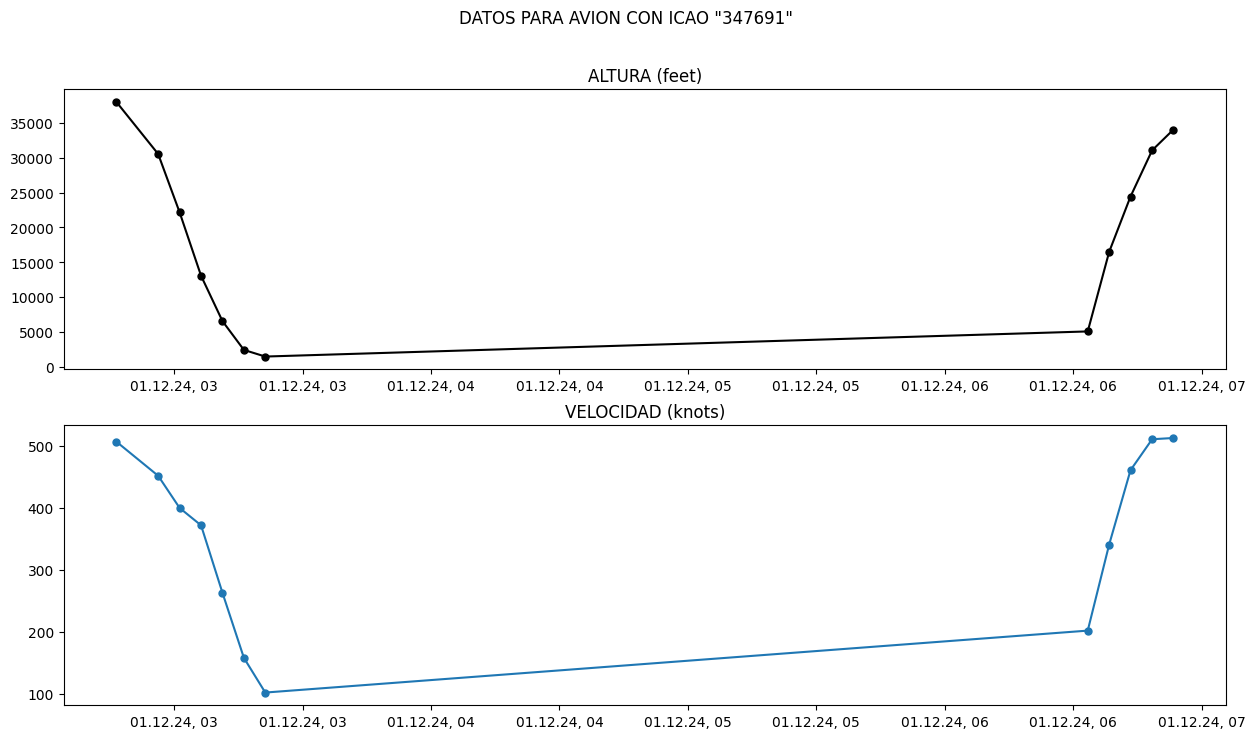

In [183]:
plot_velocity_altitude(df_altitude, '347691')

Este avion parece aterrizar y luego despegar, vemos el `ground`

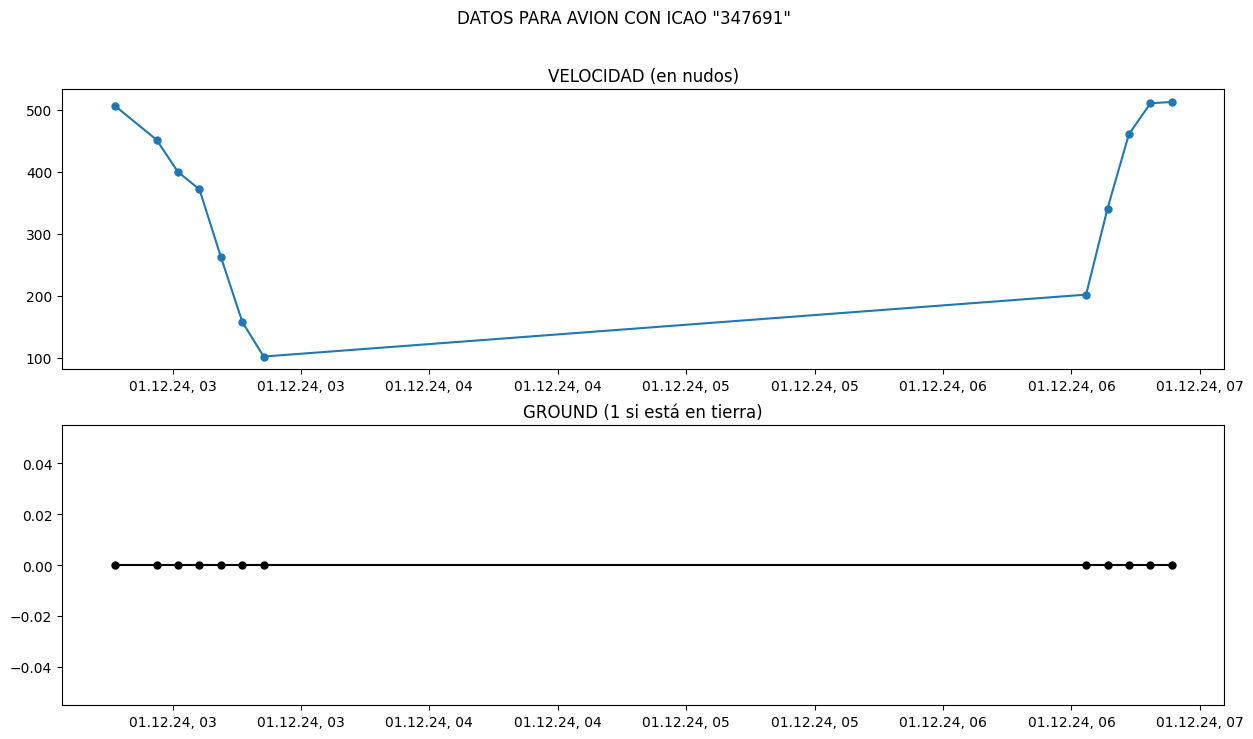

In [185]:
plot_velocity_ground(df_altitude, '347691')

Otra cosa que llama la atención, en el anterior gráfico vimos que la altura era muy baja, pero el onground no llega a 1

In [189]:
df_altitude[df_altitude.ground == 1]

,ts_kafka,velocity,lat,lon,icao,ground,direccion,alt_feet,date_time


En `df_altitude` no hay aviones que han estado en tierra